Imports

In [1]:
import torch
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

Choose device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Define classes

In [3]:
classes = ['acne', 'chickenpox', 'cowpox', 'measles', 'melanoma', 'monkeypox', 'normal', 'other', 'smallpox']

Define functions used to generate saliency maps

In [4]:
def get_saliency_bin(model, image):
    scores = model(image.unsqueeze(dim=0)).squeeze()
    scores.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.reshape(224, 224)
    return saliency

def get_saliency_multi(model, image):
    scores = model(image.unsqueeze(dim=0))
    output_idx = 5
    output_max = scores[0, output_idx]
    output_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=0)
    saliency = saliency.reshape(224, 224)
    return saliency

Load Model

In [5]:
exp = ("multiclass", "binary", "binary_2_class")[0]
if exp == 'multiclass':
    model_fc = torch.nn.Linear(2048, len(classes))
    model_path = sorted(glob("models/*multi*.pt"))[-1]
    saliency_func = get_saliency_multi
elif exp == "binary":
    model_fc = torch.nn.Sequential(
        torch.nn.Linear(2048, 1),
        torch.nn.Sigmoid()
    )
    model_path = sorted(glob("models/*bin_*.pt"))[-1]
    saliency_func = get_saliency_bin
elif exp == "binary_2_class":
    model_fc = torch.nn.Sequential(
        torch.nn.Linear(2048, 2),
        torch.nn.Softmax(dim=1)
    )
    model_path = sorted(glob("models/*bin2c_*.pt"))[-1]
    saliency_func = get_saliency_multi

In [6]:
model = resnet50()
model.fc = model_fc
model.load_state_dict(torch.load(model_path))
model = model.to(device)

Image Preprocessing using Transformations

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

Predicting disease class and extracting Saliency Map

In [14]:
image_path = sorted(glob("/home/dilith/Projects/monkeypox/data/combined/monkeypox/*"))[5]
print(image_path)
# image_path = "/home/dilith/Projects/monkeypox/data/combined/monkeypox/Moneypox_3.jpg"

pil_image = Image.open(image_path)
image = transform(pil_image)
image = image.to(device)
image.requires_grad_()
pil_image = pil_image.resize((224, 224))

disease = os.path.basename(os.path.dirname(image_path))
saliency = saliency_func(model, image)

/home/dilith/Projects/monkeypox/data/combined/monkeypox/M02_02.jpg


Visualize Saliency Map

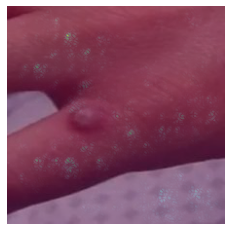

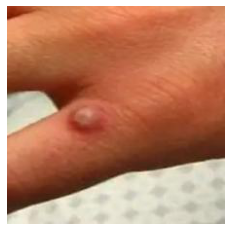

In [15]:
plt.imshow(np.asarray(pil_image))
plt.imshow(saliency.cpu(), alpha=0.5)
plt.axis('off')
plt.show()
plt.imshow(np.asarray(pil_image))
plt.axis('off')
plt.show()